In [1]:
from fastai.text import *
import html

In [2]:
PATH = Path('data/aclImdb')

In [3]:
clas_path = PATH/'imdb_clas/'
os.makedirs(clas_path, exist_ok=True)

lm_path = PATH/'imdb_lm/'
os.makedirs(lm_path, exist_ok=True)

## Get data in standard format

In [ ]:
classes = ['pos', 'neg', 'unsup']

def get_text(path):
    texts,labels = [],[]
    for idx,label in enumerate(classes):
        for fname in Path(path/label).glob('*.txt'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)

trn_texts, trn_labels = get_text(PATH/'train')
val_texts, val_labels = get_text(PATH/'test')

In [ ]:
len(trn_texts), len(val_texts)

### Shuffle data

In [ ]:
trn_idxs = np.random.permutation(len(trn_texts))
val_idxs = np.random.permutation(len(val_texts))

In [ ]:
trn_texts = trn_texts[trn_idxs]
trn_labels = trn_labels[trn_idxs]

val_texts = val_texts[val_idxs]
val_labels = val_labels[val_idxs]

### Save to csv

In [ ]:
cols = ['labels','text']

#### Classifier

In [ ]:
df_trn = pd.DataFrame({'text': trn_texts, 'labels': trn_labels}, columns=cols)
df_val = pd.DataFrame({'text': val_texts, 'labels': val_labels}, columns=cols)

In [ ]:
# remove unsup labels for classifier
df_trn[df_trn['labels'] != 2].to_csv(clas_path/'train.csv', header=False, index=False)
df_val.to_csv(clas_path/'test.csv', header=False, index=False)

In [ ]:
# save classes.txt 
(clas_path/'classes.txt').open('w').writelines(f'{o}\n' for o in classes)

#### Language Model  
Language model doesn't need any labels and can be trained on combination of trn/val data.  Predicts next word only...

In [ ]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(np.concatenate([trn_texts,val_texts]), test_size=0.1)
len(trn_texts), len(val_texts)

In [ ]:
df_trn = pd.DataFrame({'text': trn_texts, 'labels': [0]*len(trn_texts)}, columns=cols)
df_val = pd.DataFrame({'text': val_texts, 'labels': [0]*len(val_texts)}, columns=cols)

df_trn.to_csv(lm_path/'train.csv', header=False, index=False)
df_val.to_csv(lm_path/'test.csv', header=False, index=False)

## Language Model

### Tokenize

In [26]:
chunksize=24000

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [27]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [28]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    # process all multiprocessing -> parallelization
    # partition_by_cores -> takes a list and splits into number of sublists = to number of cores in computer
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [29]:
# this loops through the chunks of the dataframe.  see *chunksize* below
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [ ]:
# read csv one chunk at a time
df_trn = pd.read_csv(lm_path/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(lm_path/'test.csv', header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
' '.join(tok_trn[0])

In [ ]:
(lm_path/'tmp').mkdir(exist_ok=True)

np.save(lm_path/'tmp'/'tok_trn.npy', tok_trn)
np.save(lm_path/'tmp'/'tok_val.npy', tok_val)

In [ ]:
# tok_trn = np.load(lm_path/'tmp'/'tok_trn.npy')
# tok_val = np.load(lm_path/'tmp'/'tok_val.npy')

### Numericalize

In [ ]:
# o - text, p - word
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

In [ ]:
max_vocab=60000
min_freq=2

In [ ]:
itos = [word for word,count in freq.most_common(max_vocab) if count>min_freq]
itos.insert(0, '_unk_')
itos.insert(1, '_pad_')
len(itos)

In [ ]:
stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})

In [ ]:
# call stoi for every word in every sentence
trn_lm = np.array([[stoi[word] for word in sentence] for sentence in tok_trn])
val_lm = np.array([[stoi[word] for word in sentence] for sentence in tok_val])

In [ ]:
np.save(lm_path/'tmp'/'trn_ids.npy', trn_lm)
np.save(lm_path/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(lm_path/'tmp'/'itos.pkl', 'wb'))

In [4]:
trn_lm = np.load(lm_path/'tmp'/'trn_ids.npy')
val_lm = np.load(lm_path/'tmp'/'val_ids.npy')
itos = pickle.load(open(lm_path/'tmp'/'itos.pkl', 'rb'))

In [5]:
vs = len(itos)
vs, len(trn_lm)

(60002, 90000)

### load Wikitext103 pretrained model

In [6]:
em_sz,nh,nl = 400,1150,3

In [7]:
pre_path = PATH/'models'/'wt103'
pre_lm_path = pre_path/'fwd_wt103.h5'

In [8]:
wgts = torch.load(pre_lm_path, map_location=lambda storage, loc: storage )

In [9]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_mean = enc_wgts.mean(0)
enc_wgts.shape

(238462, 400)

In [10]:
wiki_itos = pickle.load((pre_path/'itos_wt103.pkl').open('rb'))
wiki_stoi = collections.defaultdict(lambda: -1, {v:k for k,v in enumerate(wiki_itos)})

In [11]:
# map weights from pretrained wikitext103 model onto our itos; filling unmatched values with the mean weight
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for idx,word in enumerate(itos):
    wiki_int = wiki_stoi[word]
    new_w[idx] = enc_wgts[wiki_int] if wiki_int >= 0 else row_mean

In [12]:
wgts['0.encoder.weight'] = T(new_w)
# weight tying
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [ ]:
torch.save(wgts, pre_path/'pretrained.h5')

In [8]:
wgts = torch.load(pre_path/'pretrained.h5')

### Train

In [9]:
wd = 1e-7
bptt = 70
bs = 128
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [10]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [11]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [ ]:
learner = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]

In [12]:
learner.freeze_to(-1)

# http://forums.fast.ai/t/pytorch-internal-error-while-doing-the-imdb-notebook/16828
# need to use this when training only one layer:  learner.freeze_to(-1)
torch.backends.cudnn.enabled = False

In [15]:
learner.model.load_state_dict(wgts)

In [ ]:
# learner.lr_find()

In [17]:
lr=1e-3

In [18]:
learner.fit(lr, 1, wds=wd, use_clr=(32,2), cycle_len=2)

epoch      trn_loss   val_loss   accuracy                     
    0      4.62491    4.40579    0.259161  
    1      4.531553   4.339325   0.263369                     



[4.339324908378797, 0.263369329369221]

In [19]:
learner.save('lm_last_ft')

In [ ]:
learner.load('lm_last_ft')

In [21]:
learner.unfreeze()

In [22]:
learner.fit(lr, 1, wds=wd, use_clr=(20,10), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                     
    0      4.278046   4.117441   0.285948  
    1      4.136113   4.014736   0.29587                      
    2      4.057422   3.967997   0.300487                     
    3      4.030208   3.938582   0.303337                     
    4      3.987936   3.919717   0.30507                      
    5      3.931068   3.907244   0.306769                     
    6      3.909207   3.895255   0.308176                     
    7      3.924509   3.882674   0.309208                     
    8      3.862522   3.879194   0.309961                     
    9      3.863933   3.874011   0.310501                     



[3.874011053488805, 0.3105011141070953]

In [23]:
learner.save('lm1')

In [24]:
learner.save_encoder('lm1_enc')

## Classifier

### Tokenize

In [30]:
# read csv one chunk at a time
df_trn = pd.read_csv(clas_path/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(clas_path/'test.csv', header=None, chunksize=chunksize)

In [31]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [37]:
(clas_path/'tmp').mkdir(exist_ok=True)

# np.save(clas_path/'tmp'/'tok_trn.npy', tok_trn)
# np.save(clas_path/'tmp'/'tok_val.npy', tok_val)

np.save(clas_path/'tmp'/'trn_labels.npy', trn_labels)
np.save(clas_path/'tmp'/'val_labels.npy', val_labels)

In [34]:
# itos = pickle.load(open(lm_path/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [35]:
# call stoi for every word in every sentence
trn_clas = np.array([[stoi[word] for word in sentence] for sentence in tok_trn])
val_clas = np.array([[stoi[word] for word in sentence] for sentence in tok_val])

In [38]:
np.save(clas_path/'tmp'/'trn_ids.npy', trn_clas)
np.save(clas_path/'tmp'/'val_ids.npy', val_clas)

### Build a classifier on top of LM backbone

In [ ]:
trn_clas = np.load(clas_path/'tmp'/'trn_ids.npy')
val_clas = np.load(clas_path/'tmp'/'val_ids.npy')

In [ ]:
trn_labels = np.squeeze(np.load(clas_path/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(clas_path/'tmp'/'val_labels.npy'))

In [39]:
trn_labels = np.squeeze(trn_labels)
val_labels = np.squeeze(val_labels)

In [40]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 128

In [41]:
min_lbl = trn_labels.min()  #=> 0
trn_labels -= min_lbl       #=> does nothing...
val_labels -= min_lbl       #=> does nothing...
c=int(trn_labels.max())+1   #=> 2

In [42]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, lambda x: len(trn_clas[x]), bs//2)
val_samp = SortSampler(val_clas, lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [43]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [44]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [45]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [46]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [47]:
lrs = np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
wd = 1e-7

In [48]:
learn.load_encoder('lm1_enc')

In [49]:
learn.freeze_to(-1)

In [50]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.268195   0.188965   0.92492   



[0.1889648500919342, 0.9249200000190735]

In [51]:
learn.save('clas_0')

In [52]:
learn.freeze_to(-2)

In [53]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.234426   0.183329   0.93016   
    1      0.214617   0.166109   0.93612                     



[0.1661089647054672, 0.936119999961853]

In [54]:
learn.save('clas_1')

In [58]:
learn.load('clas_1')

In [59]:
learn.unfreeze()

In [60]:
learn.fit(lrs, 1, wds=wd, cycle_len=3, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.206319   0.166992   0.93724   
    2      0.149602   0.156989   0.94224                     


[0.15698901943206786, 0.942239999961853]

In [61]:
learn.save('clas_3')

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=10, use_clr=(32,10))
learn.save('clas_2')
# overfit quickly and accuracy decreased.  Halted after 8 epochs.  ~0.94

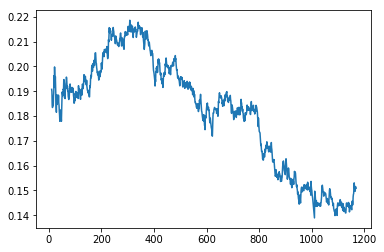

In [62]:
learn.sched.plot_loss()